## Задача 1

Реализовать класс для работы с линейной регрессией

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [ ]:
class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self,
                 regularization=None,
                 weight_calc='matrix',
                 lambda_1=None,
                 lambda_2=None,
                 batch_size=20,
                 max_iter = 10000,
                 alpha=1e-2,
                 early_stopping = 0.001):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.coef_ = None
        self.intercept_ = None
        self.alpha = alpha
        self.max_iter = max_iter
        self.early_stopping = early_stopping

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):

        if type(X) != np.ndarray:
            X = X.to_numpy()
        if type(y) != np.ndarray:
            y = y.to_numpy()

        if self.weight_calc == 'matrix':
            self.matrix_method(X, y, self.lambda_1, self.lambda_2)
        elif self.weight_calc == 'gd':
            self.gd(X, y)
        else:
            self.sgd(X, y)


    def matrix_method(self, X, y, lambda_1, lambda_2):
        if self.regularization in ['l1', 'l1l2']:
            raise TypeError("При 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.")
        n,m = X.shape
        X = np.hstack([np.ones((n, 1)), X])
        y = y.reshape(-1, 1)

        if self.regularization == 'l2':
            reg = np.eye((X.T @ X).shape[0])
            theta = np.linalg.inv(X.T @ X + self.lambda_2 * reg) @ X.T @ y
        else:
            theta = np.linalg.inv(X.T @ X) @ X.T @ y

        self.intercept_ = theta[0, 0]
        self.coef_ = theta[1:, 0]

    def gd(self, X, y):

        n, m = X.shape

        # Добавляем столбец единиц для смещения (intercept)
        X = np.hstack([np.ones((n, 1)), X])  # добавляем столбец единичных значений для intercept
        weights = np.random.randn(X.shape[1]) * 0.01  # Инициализация весов случайными малыми значениями

        for i in tqdm(range(self.max_iter)):
            # Предсказания
            predictions = X.dot(weights)

            # Ошибка
            error = predictions - y.flatten()

            # Градиент
            gradients = (2 / n) * X.T.dot(error)

            # Регуляризация
            if self.regularization == 'l1':
                gradients += self.lambda_1 * np.sign(weights)
            if self.regularization == 'l2':
                gradients += 2 * self.lambda_2 * weights
            if self.regularization == 'l1l2':
                gradients += self.lambda_1 * np.sign(weights)
                gradients += 2 * self.lambda_2 * weights

            # Обновляем веса
            weights -= self.alpha * gradients

            # Проверка на малый градиент (early stopping)
            if np.linalg.norm(gradients) < self.early_stopping:
                print(f"Early stopping at iteration {i}")
                break

            # Проверка на NaN в весах и ошибках
            if np.any(np.isnan(weights)) or np.any(np.isnan(error)):
                print(f"NaN encountered at iteration {i}. Stopping.")
                break

            # Проверка на слишком большие значения весов
            if np.any(np.abs(weights) > 1e10):
                print(f"Warning: weights are too large at iteration {i}")
                break

        self.intercept_ = weights[0]  # Первый элемент - это intercept
        self.coef_ = weights[1:]  # Остальные элементы - это коэффициенты для признаков


    def sgd(self, X, y):
        n,m = X.shape

        X = np.hstack([np.ones((n, 1)), X])  # добавляем столбец единичных значений для intercept
        weights = np.random.randn(X.shape[1]) * 0.01

        for i in tqdm(range(self.max_iter)):
            batch_indices = np.random.choice(n, self.batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            #Предсказания
            predictions = X_batch.dot(weights)

            #Ошибка
            error = predictions - y_batch#.flatten()

            #градиент
            gradients = 2 * X_batch.T.dot(error) / self.batch_size

            if self.regularization == 'l1':
                gradients += self.lambda_1 * np.sign(weights)
            if self.regularization == 'l2':
                gradients += 2 * self.lambda_2 * weights
            if self.regularization == 'l1l2':
                gradients += self.lambda_1 * np.sign(weights)
                gradients += 2 * self.lambda_2 * weights

            #обновляем веса
            weights -= self.alpha * gradients

            if np.any(np.isnan(weights)) or np.any(np.isnan(error)):
                print(f"NaN encountered at iteration {i}. Stopping.")
                break

            if np.any(np.abs(weights) > 1e10):
                print(f"Warning: weights are too large at iteration {i}")
                break

            #Проверка, что градиент не маленький
            if np.linalg.norm(gradients) < self.early_stopping:
                print(f"Early stopping at iteration {i}")
                break

        self.intercept_ = weights[0]
        self.coef_ = weights[1:]

    def predict(self, X: np.array, ss=True):
        # print("coef_.shape = ", self.coef_.shape)
        # print("intercept_.shape = ", self.intercept_.shape)
        if ss:
            return X @ self.coef_ + self.intercept_
        return X @ self.coef_

    def score_MSE(self, X: np.array, y: np.array):
        y_pred = self.predict(X)
        return np.mean((y_pred - y) ** 2)

    def score_MAE(self, X: np.array, y: np.array):
        y_pred = self.predict(X)
        return np.mean(np.abs(y_pred - y))

#1

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы.

In [ ]:
data = pd.read_csv('/content/Used_fiat_500_in_Italy_dataset.csv')
data.head(3)

,model,engine_power,transmission,age_in_days,km,previous_owners,lat,lon,price
0,pop,69,manual,4474,56779,2,45.071079,7.46403,4490
1,lounge,69,manual,2708,160000,1,45.069679,7.70492,4500
2,lounge,69,automatic,3470,170000,2,45.514599,9.28434,4500


In [ ]:
x = np.cos(data['lat']) * np.cos(data['lon'])
y = np.cos(data['lat']) * np.sin(data['lon'])
z = np.sin(data['lat'])

In [ ]:
data.drop(columns=['lat', 'lon'], inplace=True)
data['x'] = x
data['y'] = y
data['z'] = z

In [ ]:
data['engine_power'] = data['engine_power'].astype(object)
data['previous_owners'] = data['previous_owners'].astype(object)

In [ ]:
categorical

Index(['model', 'engine_power', 'transmission', 'previous_owners'], dtype='object')

In [ ]:
X

,model,engine_power,transmission,age_in_days,km,previous_owners,lat,lon
0,pop,69,manual,4474,56779,2,45.071079,7.46403
1,lounge,69,manual,2708,160000,1,45.069679,7.70492
2,lounge,69,automatic,3470,170000,2,45.514599,9.28434
3,sport,69,manual,3288,132000,2,41.903221,12.49565
4,sport,69,manual,3712,124490,2,45.532661,9.03892
...,...,...,...,...,...,...,...,...
375,lounge,69,manual,4474,55976,2,45.610050,9.24234
376,lounge,69,manual,4200,134717,1,44.102020,9.82024
377,lounge,69,manual,3470,113344,1,41.003799,16.87294
378,pop,69,automatic,3712,130000,1,45.810501,8.96474


In [ ]:
from sklearn.cluster import KMeans
coordinates = data[['lat', 'lon']].to_numpy()
# Конвертируем координаты в массив numpy

# Инициализация и настройка K-means
n_clusters = 10 # Количество кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(coordinates)

# Получение меток кластеров
data['cluster'] = kmeans.labels_

In [ ]:
X = data.drop(columns=['price'])
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# from sklearn.preprocessing import StandardScaler

# numcol = X_train.select_dtypes(include=np.number)
# numeric_features = numcol.columns

# strcol = X_train.select_dtypes(include=object)
# categorical = strcol.columns

# print(pd.get_dummies(X_train, columns=categorical).columns)
# print(pd.get_dummies(X_test, columns=categorical).columns)

# # Get missing columns in the training test
# missing_cols = set( X_train.columns ) - set( X_test.columns )
# # Add a missing column in test set with default value equal to 0
# for c in missing_cols:
#     X_test[c] = 0

Index(['age_in_days', 'km', 'x', 'y', 'z', 'model_lounge', 'model_pop',
       'model_sport', 'model_star', 'engine_power_69', 'engine_power_84',
       'engine_power_99', 'engine_power_101', 'transmission_automatic',
       'transmission_manual', 'previous_owners_1', 'previous_owners_2',
       'previous_owners_3', 'previous_owners_4'],
      dtype='object')
Index(['age_in_days', 'km', 'x', 'y', 'z', 'model_lounge', 'model_pop',
       'model_sport', 'engine_power_69', 'engine_power_99',
       'transmission_automatic', 'transmission_manual', 'previous_owners_1',
       'previous_owners_2', 'previous_owners_3'],
      dtype='object')


In [ ]:
print(X_train.shape)
print(X_test.shape)

(304, 19)
(76, 19)


In [ ]:
from sklearn.preprocessing import StandardScaler

numcol = X_train.select_dtypes(include=np.number)
numeric_features = numcol.columns

strcol = X_train.select_dtypes(include=object)
categorical = strcol.columns

X_train = pd.get_dummies(X_train, columns=categorical, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical, drop_first=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train[numeric_features] = X_train_scaled
X_test[numeric_features] = X_test_scaled

missing_cols = set( X_train.columns ) - set( X_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0

In [ ]:
X_train.head(3)

,age_in_days,km,lat,lon,cluster,model_pop,model_sport,model_star,engine_power_84,engine_power_99,engine_power_101,transmission_manual,previous_owners_2,previous_owners_3,previous_owners_4
77,-2.137739,-1.832832,0.665380,-0.844762,-0.741881,False,False,False,False,False,False,True,True,False,False
220,0.574300,-0.467736,0.669284,-0.246397,0.511074,False,False,False,False,False,False,True,True,False,False
297,-2.029171,-0.465588,0.666578,0.093047,0.511074,True,False,False,False,False,False,False,False,False,False


In [ ]:
hyperparams = {'regularization': ['None', 'l1', 'l2', 'l1l2'],
 'weight_calc': ['gd', 'sgd', 'matrix'],
 'lambda_1': [1, 0.1, 0.01, 0.001],
 'lambda_2': [1, 0.1, 0.01, 0.001],
 'batch_size': [20, 40, 60, 80]}

In [ ]:
hyperparams = [
    {'regularization': None, 'weight_calc': 'gd'},
    {'regularization': None, 'weight_calc': 'sgd'},
    {'regularization': None, 'weight_calc': 'matrix'},

    {'regularization': 'l2', 'weight_calc': 'matrix', 'lambda_2': 0.01},
    {'regularization': 'l2', 'weight_calc': 'matrix', 'lambda_2': 0.001},

    {'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 1},
    {'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.1},
    {'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.01},
    {'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.001},

    {'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.001},
    {'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.0001},
    {'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.00001},
    {'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.000001},

    {'regularization': 'l1l2', 'weight_calc': 'gd', 'lambda_1': 1, 'lambda_2': 1},
    {'regularization': 'l1l2', 'weight_calc': 'gd', 'lambda_1': 0.1, 'lambda_2': 0.1},
    {'regularization': 'l1l2', 'weight_calc': 'gd', 'lambda_1': 0.01, 'lambda_2': 0.01},
    {'regularization': 'l1l2', 'weight_calc': 'gd', 'lambda_1': 0.001, 'lambda_2': 0.001},

    {'regularization': 'l1', 'weight_calc': 'sgd', 'lambda_1': 1},
    {'regularization': 'l1', 'weight_calc': 'sgd', 'lambda_1': 0.1},
    {'regularization': 'l1', 'weight_calc': 'sgd', 'lambda_1': 0.01},
    {'regularization': 'l1', 'weight_calc': 'sgd', 'lambda_1': 0.001},

    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.001},
    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.0001},
    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.0001},
    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.00001},

    {'regularization': 'l1l2', 'weight_calc': 'sgd', 'lambda_1': 0.001, 'lambda_2': 1},
    {'regularization': 'l1l2', 'weight_calc': 'sgd', 'lambda_1': 0.01, 'lambda_2': 0.1},
    {'regularization': 'l1l2', 'weight_calc': 'sgd', 'lambda_1': 0.1, 'lambda_2': 0.01},
    {'regularization': 'l1l2', 'weight_calc': 'sgd', 'lambda_1': 1, 'lambda_2': 0.001},

    {'regularization': None, 'weight_calc': 'sgd', "batch_size": 20},
    {'regularization': None, 'weight_calc': 'sgd', "batch_size": 40},
    {'regularization': None, 'weight_calc': 'sgd', "batch_size": 60},

    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.001, "batch_size": 2},
    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.001, "batch_size": 20},
    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.001, "batch_size": 40},
    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.001, "batch_size": 60},
    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.001, "batch_size": 80},
    {'regularization': 'l2', 'weight_calc': 'sgd', 'lambda_2': 0.001, "batch_size": 150},
]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
print(X_train.shape)
print(X_test.shape)

(304, 15)
(76, 15)


In [ ]:
X_train_droped = X_train.drop(columns=['lat', 'lon'])
X_test_droped = X_test.drop(columns=['lat', 'lon'])

In [ ]:
# results = []
len_test=3
# parametrs = np.zeros((len(hyperpa
# rams), 5))
weights = np.zeros((len(hyperparams), len_test, 13))
MSE = np.zeros((len(hyperparams), len_test))
MAE = np.zeros((len(hyperparams), len_test))
times = np.zeros((len(hyperparams), len_test))
R2 = np.zeros((len(hyperparams), len_test))


for i in tqdm(range(len_test)):
  j=0
  for params in hyperparams:
      model = MyLinearRegression(**params, max_iter=10000,
                            early_stopping=1e-5, alpha=1e-2)

      # Измеряем время обучения
      start_time = time.time()
      # print(params)
      model.fit((X_train_droped*1).to_numpy(), y_train.to_numpy())
      # model.fit(X_train_scaled , y_train.to_numpy() )
      training_time = time.time() - start_time


      # Измеряем время предсказания
      start_time = time.time()
      y_pred = model.predict((X_test_droped*1).to_numpy())
      prediction_time = time.time() - start_time

      # Оценка качества модели
      mse = mean_squared_error(y_test, y_pred)
      mae = mean_absolute_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)

      MSE[j][i] = mse
      MAE[j][i] = mae
      times[j][i] = training_time
      R2[j][i] = r2
      weights[j][i] = model.coef_
      j += 1

print()

100%|██████████| 10000/10000 [00:00<00:00, 30084.55it/s]

100%|██████████| 10000/10000 [00:00<00:00, 14006.36it/s]

100%|██████████| 10000/10000 [00:00<00:00, 23686.02it/s]

100%|██████████| 10000/10000 [00:00<00:00, 26284.58it/s]

100%|██████████| 10000/10000 [00:00<00:00, 23760.42it/s]

100%|██████████| 10000/10000 [00:00<00:00, 26737.08it/s]

100%|██████████| 10000/10000 [00:00<00:00, 23881.08it/s]

100%|██████████| 10000/10000 [00:00<00:00, 28026.02it/s]

100%|██████████| 10000/10000 [00:00<00:00, 27402.49it/s]

100%|██████████| 10000/10000 [00:00<00:00, 24449.44it/s]

  8%|▊         | 820/10000 [00:00<00:00, 27622.47it/s]


Early stopping at iteration 820



 67%|██████▋   | 6689/10000 [00:00<00:00, 25927.97it/s]


Early stopping at iteration 6689



100%|██████████| 10000/10000 [00:00<00:00, 22323.74it/s]

100%|██████████| 10000/10000 [00:00<00:00, 25783.27it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13072.86it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13329.64it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13460.17it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9165.83it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9026.08it/s]

100%|██████████| 10000/10000 [00:01<00:00, 8186.49it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9278.89it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12771.70it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13404.14it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12552.02it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12705.43it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12712.19it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13795.69it/s]

100%|██████████| 10000/10000 [00:00<00:00, 14095.92it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13371.13it/s]

100%|██████████| 

Early stopping at iteration 820



 67%|██████▋   | 6689/10000 [00:00<00:00, 25410.49it/s]


Early stopping at iteration 6689



100%|██████████| 10000/10000 [00:00<00:00, 26080.69it/s]

100%|██████████| 10000/10000 [00:00<00:00, 21202.14it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12627.79it/s]

100%|██████████| 10000/10000 [00:00<00:00, 14145.08it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13019.09it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12870.81it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13225.53it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13978.83it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13303.45it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9179.67it/s]

100%|██████████| 10000/10000 [00:01<00:00, 7768.94it/s]

100%|██████████| 10000/10000 [00:01<00:00, 7698.29it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9857.55it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12255.45it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13961.67it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13614.06it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13290.69it/s]

100%|██████████| 

Early stopping at iteration 820



 67%|██████▋   | 6689/10000 [00:00<00:00, 25554.50it/s]


Early stopping at iteration 6689



100%|██████████| 10000/10000 [00:00<00:00, 22692.47it/s]

100%|██████████| 10000/10000 [00:00<00:00, 26203.93it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12899.50it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12529.01it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13027.05it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13357.58it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12628.38it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13036.10it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13159.93it/s]

100%|██████████| 10000/10000 [00:00<00:00, 13917.34it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12140.56it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12176.56it/s]

100%|██████████| 10000/10000 [00:00<00:00, 10389.19it/s]

100%|██████████| 10000/10000 [00:01<00:00, 8236.01it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9126.36it/s]

100%|██████████| 10000/10000 [00:01<00:00, 8553.90it/s]

100%|██████████| 10000/10000 [00:00<00:00, 10536.97it/s]

100%|██████████|

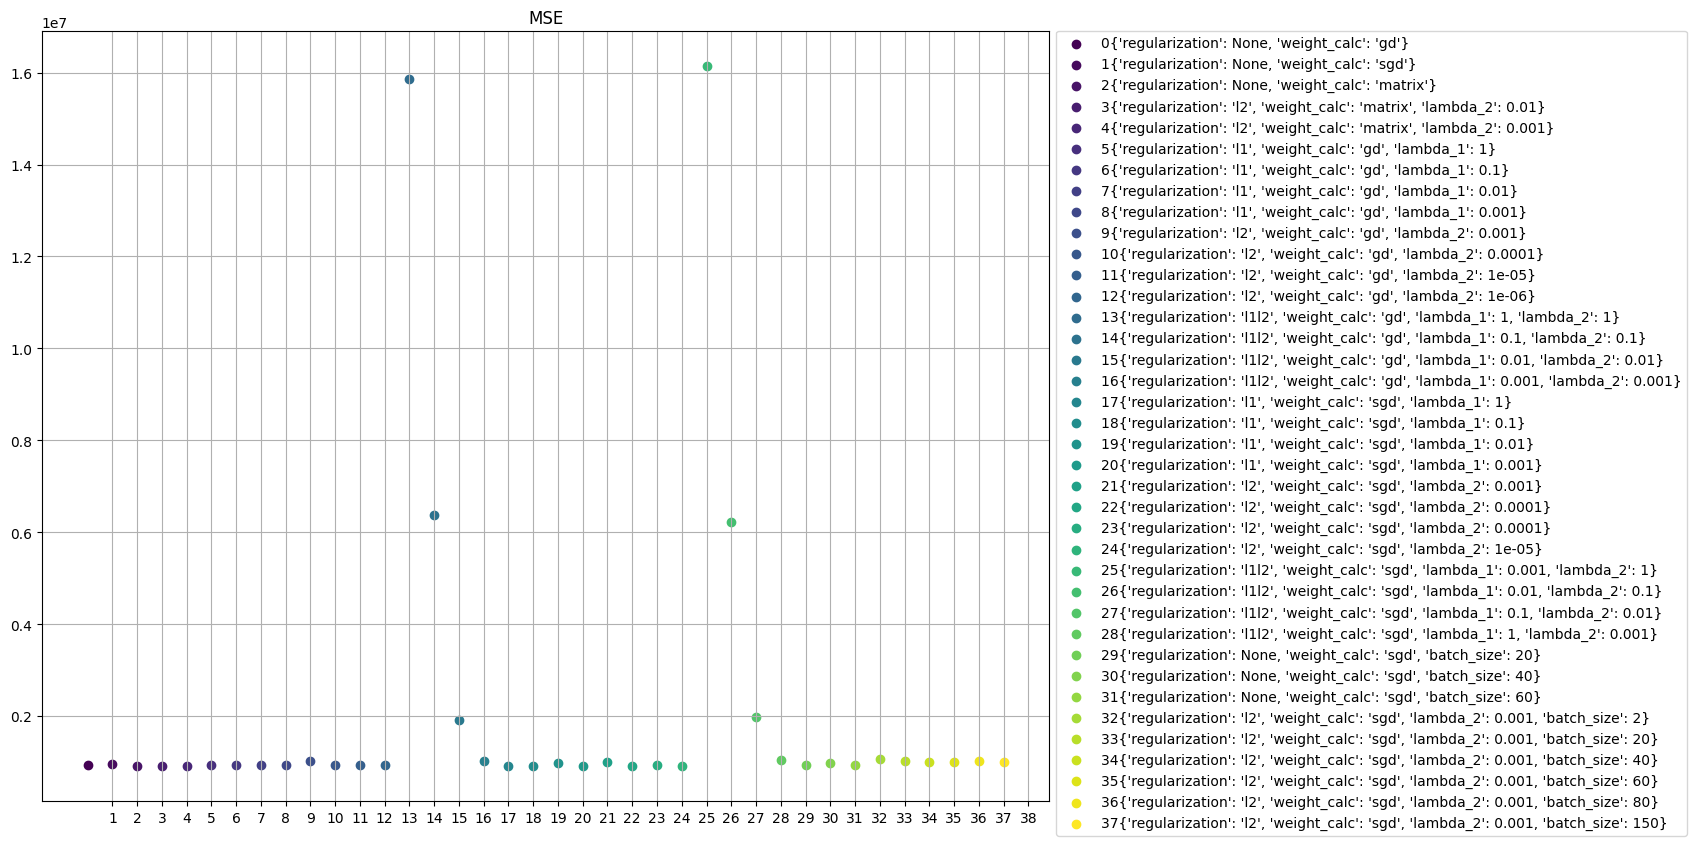

In [ ]:
len_hypers = len(hyperparams)

x = np.linspace(1, len_hypers, len_hypers)

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len_hypers)]

plt.figure(figsize=(13,10))
for i, val in enumerate(MSE):
    m = np.mean(val)
    # plt.axvline(x = i, color = 'black', ymin=0, ymax = m)
    plt.scatter(i, m, color=colors[i], label=str(i) + str(hyperparams[i]))

plt.xticks(x)
plt.grid()
plt.legend(bbox_to_anchor=(1, 1.01))
plt.title("MSE")
plt.show()

In [ ]:
dict_MSE = {}
for key, val in zip(hyperparams, MSE):
    dict_MSE[str(key)] = np.mean(val)
dict_MSE

{"{'regularization': None, 'weight_calc': 'gd'}": 923425.2511838228,
 "{'regularization': None, 'weight_calc': 'sgd'}": 946075.7185607663,
 "{'regularization': None, 'weight_calc': 'matrix'}": 904474.9678939377,
 "{'regularization': 'l2', 'weight_calc': 'matrix', 'lambda_2': 0.01}": 907136.0849838243,
 "{'regularization': 'l2', 'weight_calc': 'matrix', 'lambda_2': 0.001}": 904740.1350075469,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 1}": 934374.5745777981,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.1}": 924458.6434173192,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.01}": 923527.9526024344,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.001}": 923435.8910455354,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.001}": 1012743.2791576451,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.0001}": 932088.638890495,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 1e-05}": 924288.6448799

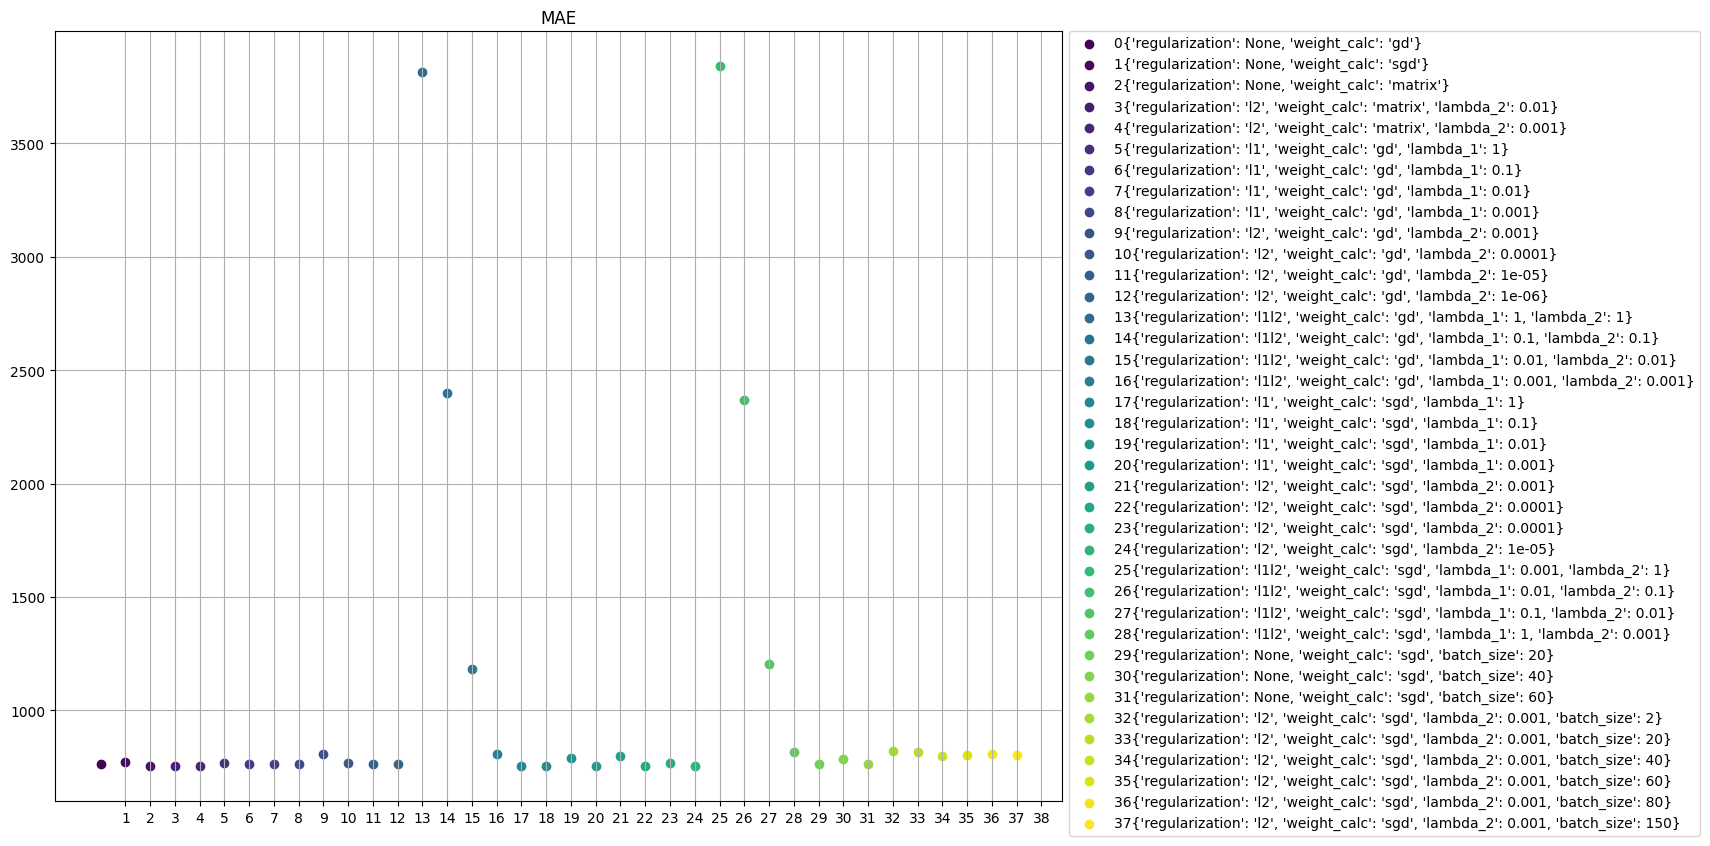

In [ ]:
len_hypers = len(hyperparams)

x = np.linspace(1, len_hypers, len_hypers)

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len_hypers)]

plt.figure(figsize=(13,10))
for i, val in enumerate(MAE):
    m = np.mean(val)
    # plt.axvline(x = i, color = 'black', ymin=0, ymax = m)
    plt.scatter(i, m, color=colors[i], label=str(i) + str(hyperparams[i]))

plt.xticks(x)
plt.grid()
plt.legend(bbox_to_anchor=(1, 1.01))
plt.title("MAE")
plt.show()

In [ ]:
dict_MAE = {}
for key, val in zip(hyperparams, MAE):
    dict_MAE[str(key)] = np.mean(val)
dict_MAE

{"{'regularization': None, 'weight_calc': 'gd'}": 761.4223737593097,
 "{'regularization': None, 'weight_calc': 'sgd'}": 772.1697972500514,
 "{'regularization': None, 'weight_calc': 'matrix'}": 754.7877666010614,
 "{'regularization': 'l2', 'weight_calc': 'matrix', 'lambda_2': 0.01}": 756.2166992207345,
 "{'regularization': 'l2', 'weight_calc': 'matrix', 'lambda_2': 0.001}": 754.9210767051896,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 1}": 765.9607301449124,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.1}": 761.8777740815661,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.01}": 761.4679217011766,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.001}": 761.4270628828343,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.001}": 807.7225304699001,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.0001}": 766.137009072601,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 1e-05}": 761.89530434940

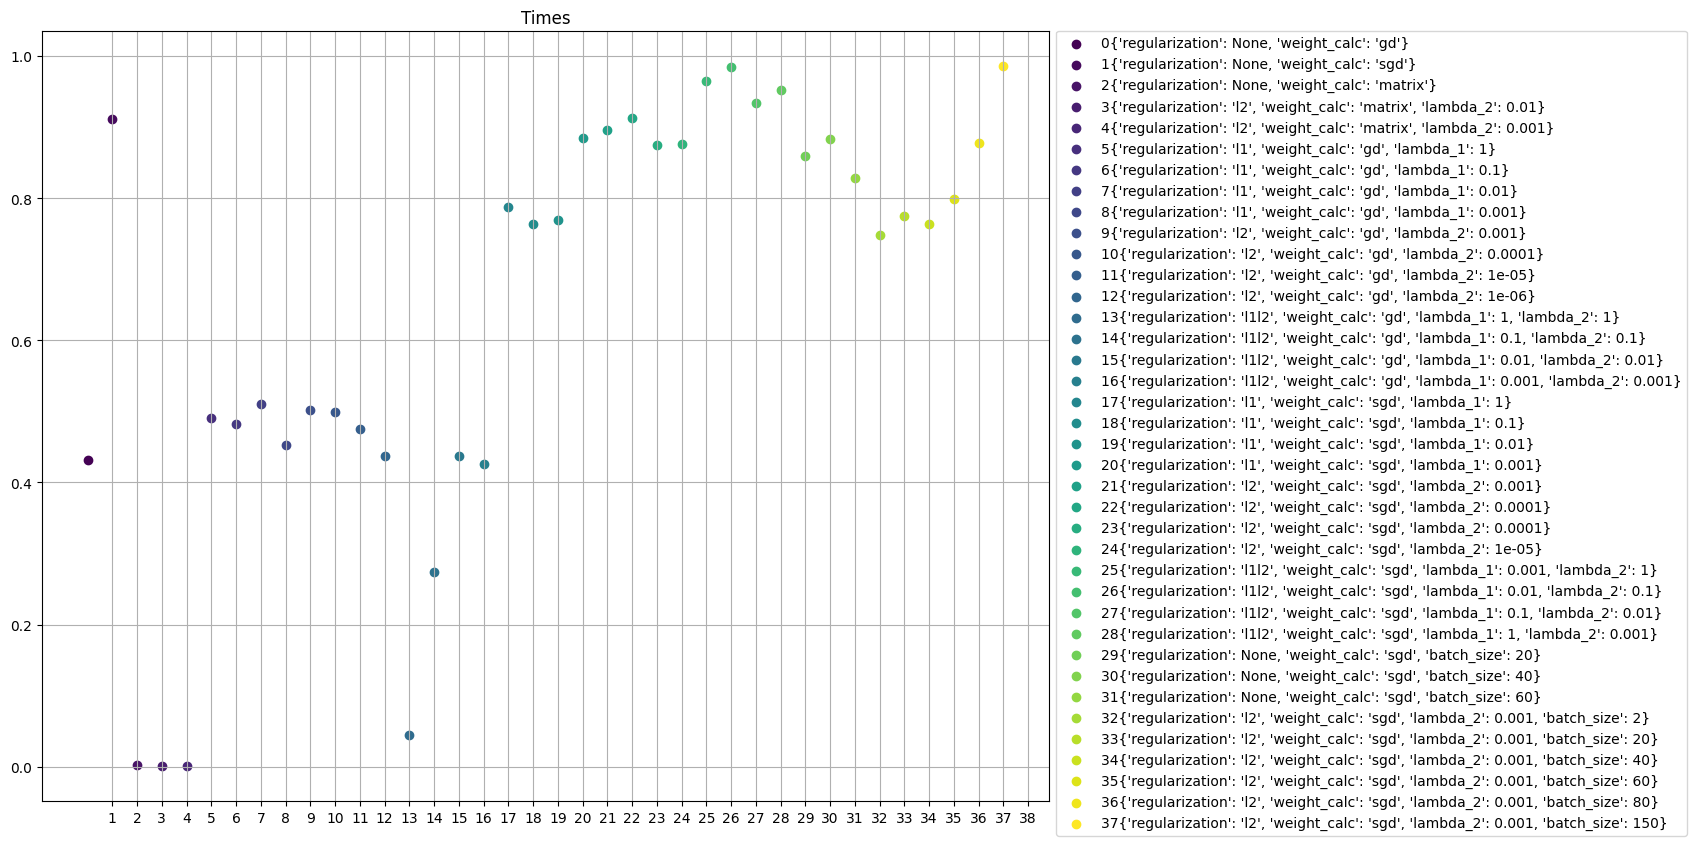

In [ ]:
len_hypers = len(hyperparams)

x = np.linspace(1, len_hypers, len_hypers)

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len_hypers)]

plt.figure(figsize=(13,10))
for i, val in enumerate(times):
    m = np.mean(val)
    # plt.axvline(x = i, color = 'black', ymin=0, ymax = m)
    plt.scatter(i, m, color=colors[i], label=str(i) + str(hyperparams[i]))

plt.xticks(x)
plt.grid()
plt.legend(bbox_to_anchor=(1, 1.01))
plt.title("Times")
plt.show()

In [ ]:
dict_times = {}
for key, val in zip(hyperparams, times):
    dict_times[str(key)] = np.mean(val)
dict_times

{"{'regularization': None, 'weight_calc': 'gd'}": 0.43120090166727704,
 "{'regularization': None, 'weight_calc': 'sgd'}": 0.911702553431193,
 "{'regularization': None, 'weight_calc': 'matrix'}": 0.0020368099212646484,
 "{'regularization': 'l2', 'weight_calc': 'matrix', 'lambda_2': 0.01}": 0.0006929238637288412,
 "{'regularization': 'l2', 'weight_calc': 'matrix', 'lambda_2': 0.001}": 0.0013241767883300781,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 1}": 0.49129541714986164,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.1}": 0.4827572504679362,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.01}": 0.5109144051869711,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.001}": 0.452006737391154,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.001}": 0.5013915697733561,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.0001}": 0.49872422218322754,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 1e

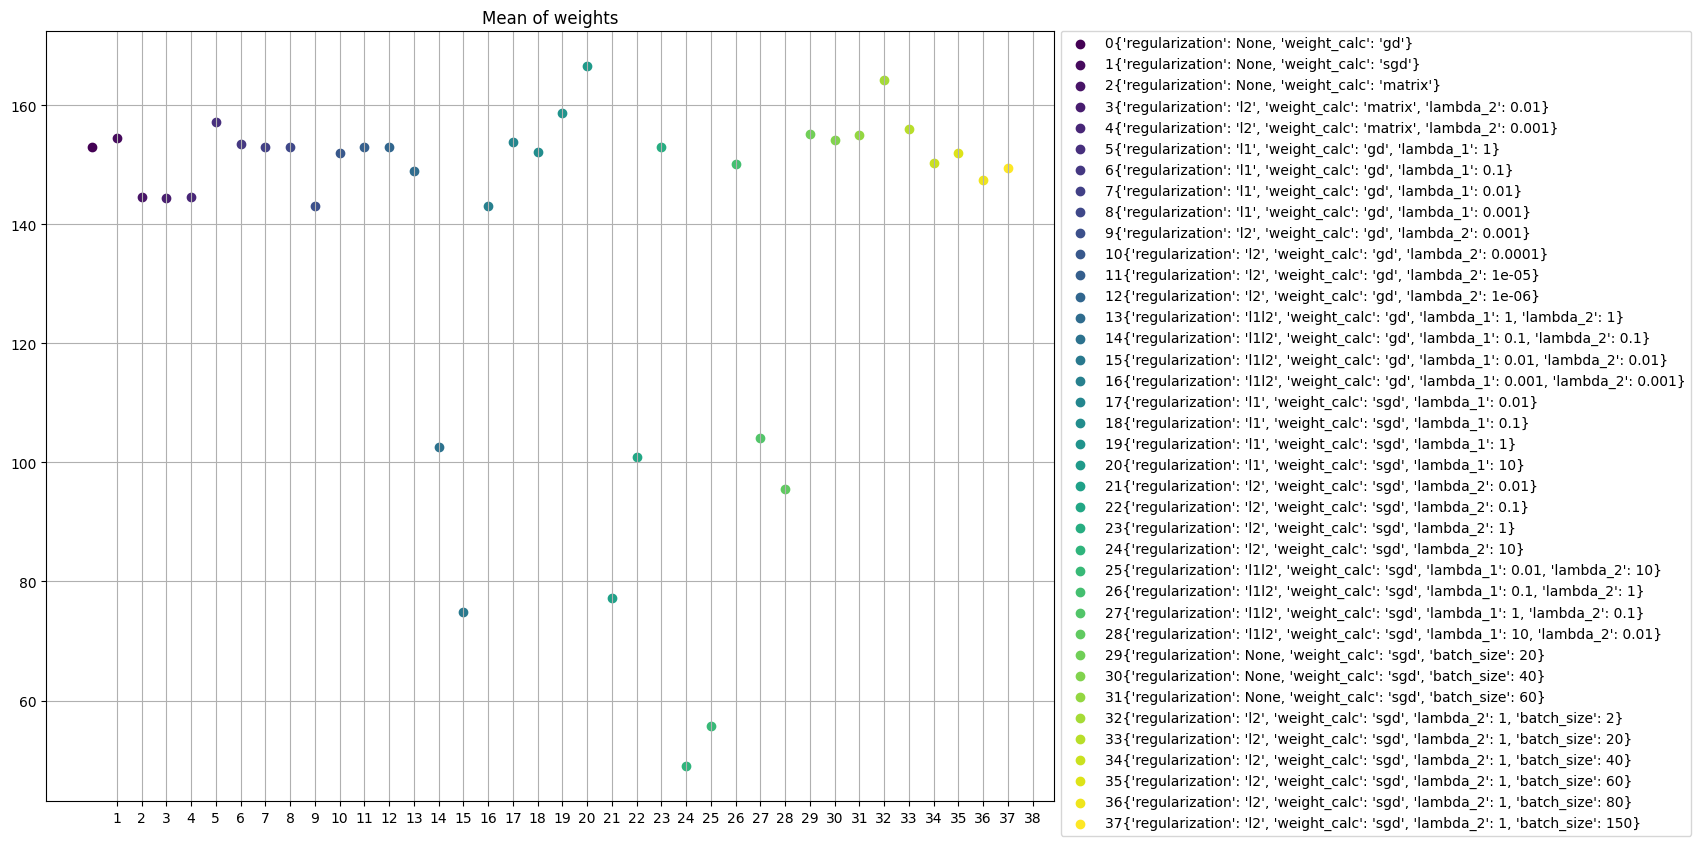

In [ ]:
len_hypers = len(hyperparams)

x = np.linspace(1, len_hypers, len_hypers)

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len_hypers)]

plt.figure(figsize=(13,10))
for i, val in enumerate(weights):
    m = abs(np.mean(val))
    # plt.axvline(x = i, color = 'black', ymin=0, ymax = m)
    plt.scatter(i, m, color=colors[i], label=str(i) + str(hyperparams[i]))

plt.xticks(x)
plt.grid()
plt.legend(bbox_to_anchor=(1, 1.01))
plt.title("Mean of weights")
plt.show()

###weight_calc:

matrix метод при небольших наборах данных может обеспечивать более быстрое решение.

gd и sgd подходят для более больших данных.

В sgd обучение в общем случае происходит быстро благодаря частым обновлениям параметров, но может потребовать больше итераций для достижения сходимости.

###regularization:

l1 регуляризация может обеспечивать обнуление ненужных параметров, чего не было замечено в данном примере.

l2 регуляризация не дает весам быть слишком большими. l1l2 регуляризация совмещает себе оба регуляризатора.

Параметры lambda могут быть настроены так, чтобы давать меньшие веса.

###alpha:

Влияет на скорость обучения. При малых значениях скорость может длиться долго, при больших перескакивать минимум.

###batch_size:
Может влиять скорость обучения. Чем больше размер батча, тем медленнее обучение.

In [ ]:
dict_weights = {}
for key, val in zip(hyperparams, weights):
    dict_weights[str(key)] = np.mean(val, axis=0)
dict_weights

{"{'regularization': None, 'weight_calc': 'gd'}": array([-1600.40890274,  -492.62846691,    95.59068181,    81.63540249,
           73.06147124,   330.16703867,  -801.01197895,   291.62340223,
          214.74499916,   -24.37587184,    88.35194447,   285.40460355,
         -531.82785704]),
 "{'regularization': None, 'weight_calc': 'sgd'}": array([-1569.69842476,  -494.52845931,    88.88299062,    76.92675784,
           68.65127424,   332.02453564,  -795.76641415,   282.68539264,
          218.44990941,    -9.98051939,    91.03541584,   287.51520151,
         -540.39858109]),
 "{'regularization': None, 'weight_calc': 'matrix'}": array([-1600.68828006,  -489.76120902,    95.19879436,    81.22827612,
           77.32949631,   651.54576953,  -802.38365422,   288.16993641,
          210.28464687,   -30.8637188 ,    87.88947333,   294.6916599 ,
         -741.87014812]),
 "{'regularization': 'l2', 'weight_calc': 'matrix', 'lambda_2': 0.01}": array([-1600.65862944,  -489.82034921,    95.10966

In [ ]:
import seaborn as sns

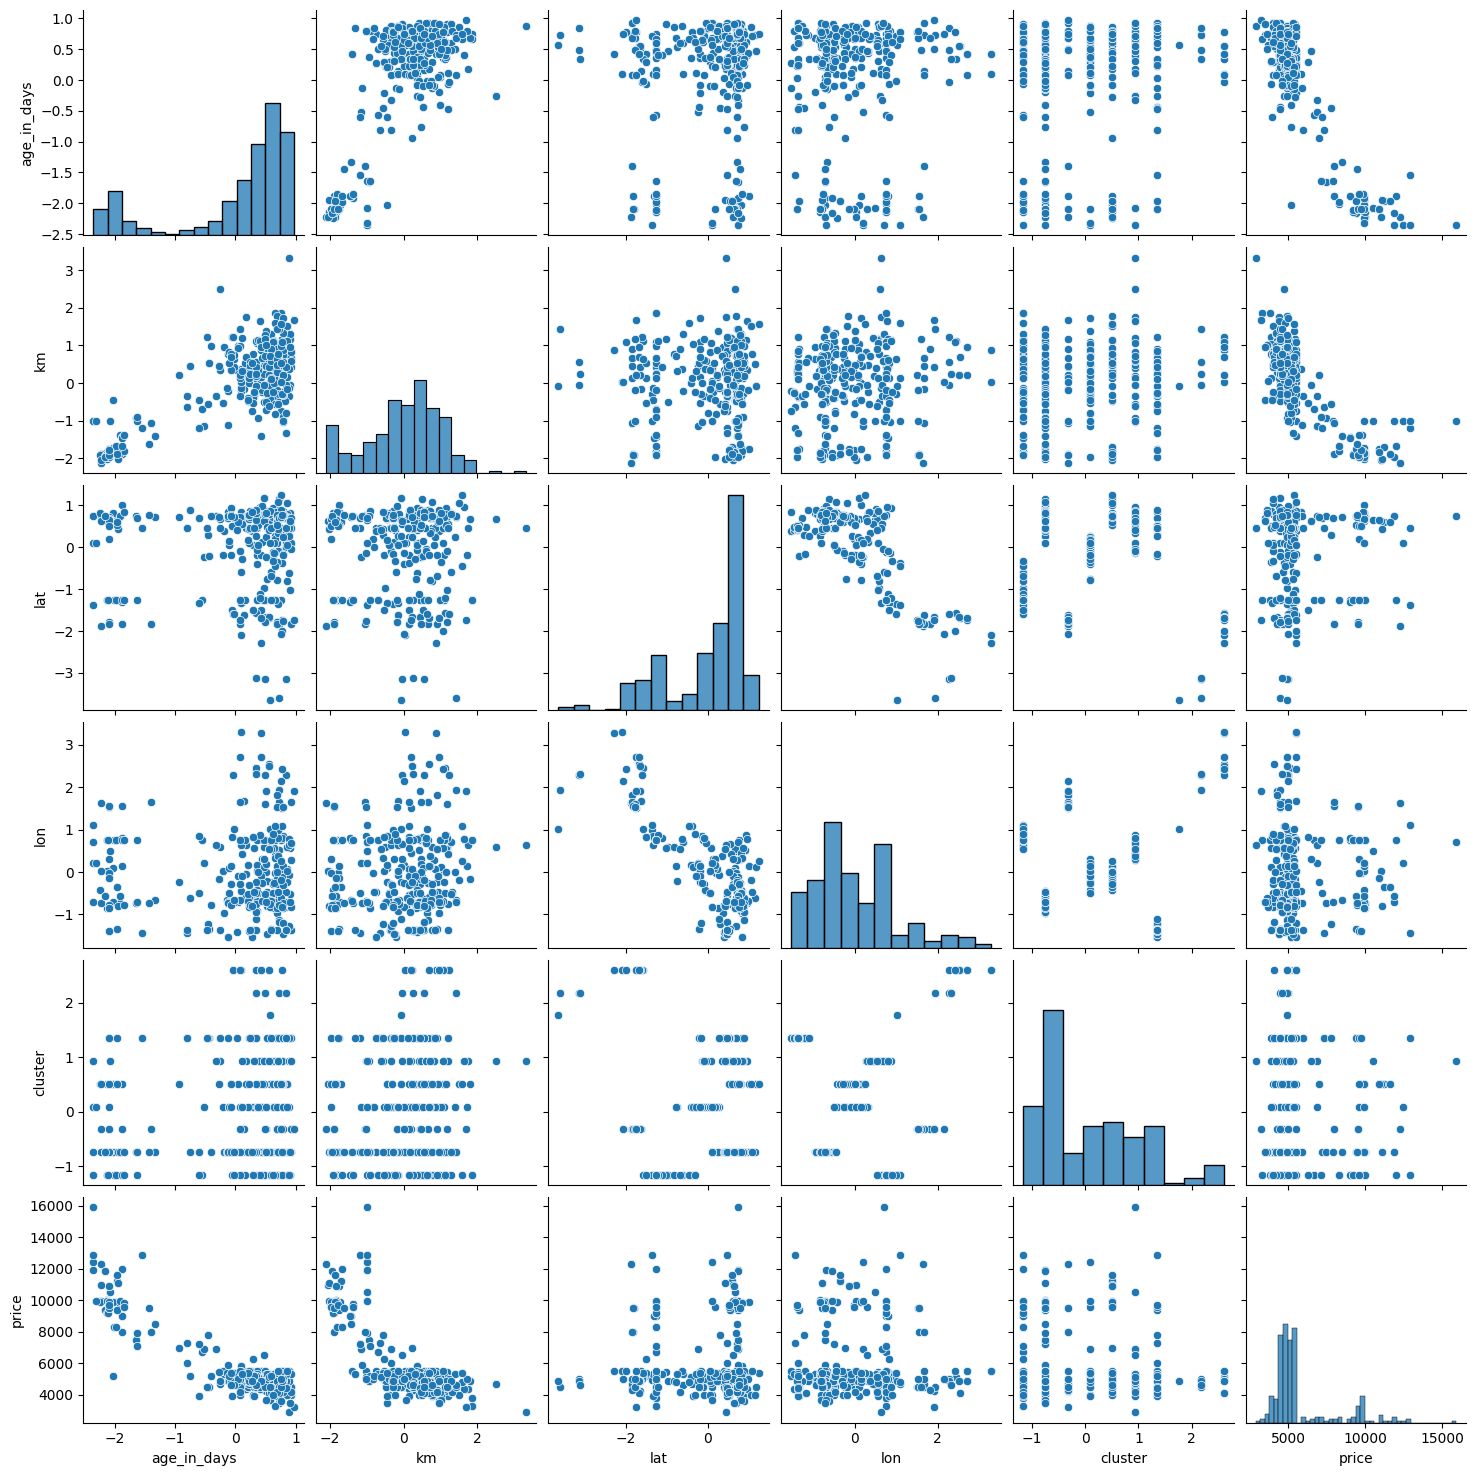

In [ ]:
sns.pairplot(pd.concat([X_train[numeric_features], y_train], axis=1))

In [ ]:
dict_weights = {}
for key, val in zip(hyperparams, weights):
    dict_weights[str(key)] = np.mean(val)
dict_weights

{"{'regularization': None, 'weight_calc': 'gd'}": -153.05185425756923,
 "{'regularization': None, 'weight_calc': 'sgd'}": -155.56053073412838,
 "{'regularization': None, 'weight_calc': 'matrix'}": -144.55607364619632,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 1}": -157.14554137299018,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.1}": -153.4632508789585,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.01}": -153.09356948405556,
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.001}": -153.05583690114526,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 1}": 149.2483768115231,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.1}": 102.68614362484993,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.01}": -74.76565683885899,
 "{'regularization': 'l2', 'weight_calc': 'gd', 'lambda_2': 0.001}": -143.1141041024084,
 "{'regularization': None, 'weight_calc': 'sgd', 'batch_size': 20}": -151.81438310

In [ ]:
dict_results = {}
for key, mse, mase, t, w in zip(hyperparams, MSE, MAE, times, weights):
    dict_results[str(key) + " mse, mae, time, weights"] = [np.mean(mse), np.mean(mae), np.mean(t), np.mean(w)]
dict_results

{"{'regularization': None, 'weight_calc': 'gd'} mse, mae, time, weights": [923425.367085836,
  760.029716957336,
  0.4793549378712972,
  -153.05185425756923],
 "{'regularization': None, 'weight_calc': 'sgd'} mse, mae, time, weights": [919610.7412090824,
  760.029716957336,
  1.0255578358968098,
  -155.56053073412838],
 "{'regularization': None, 'weight_calc': 'matrix'} mse, mae, time, weights": [904474.9678939377,
  760.029716957336,
  0.002066453297932943,
  -144.55607364619632],
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 1} mse, mae, time, weights": [934374.4987508418,
  760.029716957336,
  0.5601643721262614,
  -157.14554137299018],
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.1} mse, mae, time, weights": [924458.4529924592,
  760.029716957336,
  0.509520689646403,
  -153.4632508789585],
 "{'regularization': 'l1', 'weight_calc': 'gd', 'lambda_1': 0.01} mse, mae, time, weights": [923528.5950241,
  760.029716957336,
  0.5301644802093506,
  -153.093569

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

model = MyLinearRegression(weight_calc = 'sgd',
                           alpha=1e-2,
                           max_iter=10000,
                            early_stopping=1e-1,
                            lambda_1=0.01,
                            lambda_2=0.01,
                            regularization='l1',
                          batch_size = 20)
model.fit((X_train*1).to_numpy() , y_train.to_numpy() )
y_pred = model.predict((X_test*1).to_numpy())
y_train_pred = model.predict((X_train*1).to_numpy())

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print('Test R2 = %.4f' % r2_score(y_test, y_pred) )
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))
print('Train R2 = %.4f' % r2_score(y_train, y_train_pred) )

100%|██████████| 10000/10000 [00:00<00:00, 14334.64it/s]


Test MSE = 837032.7700
Test R2 = 0.8360
Train MSE = 707368.6741
Train R2 = 0.8450
